# 파일 kaggle에서 다운로드해서 압축풀기

In [ ]:
! kaggle datasets download -d pranavraikokte/covid19-image-dataset

Dataset URL: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset
License(s): CC-BY-SA-4.0
100% 158M/158M [00:01<00:00, 158MB/s]
100% 158M/158M [00:01<00:00, 158MB/s]


In [ ]:
! unzip -qq 'covid19-image-dataset.zip'

# 학습 / 테스트 데이터셋 생성

# 학습 데이터셋

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rotation_range=10, # 이미지를 무작위 회전시킬 최대 각도
                                     zoom_range=0.2, # 1-0.2 == 0.8배에서 1+0.2==1.2배 무작위로 이미지 스케일을 확대 또는 축소
                                     horizontal_flip=True, # 이미지를 수평 뒤집기
                                     rescale=1/255)  # 정규화

In [ ]:
train_dataset = train_generator.flow_from_directory(directory='/content/Covid19-dataset/train',
                                                    target_size=(299, 299), # 다중 클래스 분류
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    shuffle=True,
                                                    seed=10)

Found 251 images belonging to 3 classes.


In [ ]:
print(train_dataset.classes)         # 클래스는 0 1 2
print(train_dataset.class_indices)   # 코로나는 0 정상은 1 폐렴이 2

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


In [ ]:
import numpy as np
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2], dtype=int32), array([111,  70,  70]))

# 테스트 데이터셋

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255)

test_dataset = test_generator.flow_from_directory(directory='/content/Covid19-dataset/test',
                                                  target_size=(299, 299),
                                                  class_mode='categorical',
                                                  batch_size=1,
                                                  shuffle=False,  # 테스트를 셔플하면 평가할때 값이 계속 바뀜
                                                  seed=10)

Found 66 images belonging to 3 classes.


# 모델 구성

In [ ]:
### Sequential 모델
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

num_classes = 3         ### 클래스값(0,1)
num_detectors = 32
width, height = 299,299   ### 입력 이미지 사이즈

Sequential_model = Sequential()

Sequential_model.add(Conv2D(filters=num_detectors, kernel_size=3, activation='relu', padding='same', input_shape=(width, height, 3)))
Sequential_model.add(BatchNormalization())

Sequential_model.add(Conv2D(filters=num_detectors, kernel_size=3, activation='relu', padding='same'))
Sequential_model.add(MaxPooling2D(pool_size=(2, 2)))
Sequential_model.add(Dropout(0.2))

Sequential_model.add(Conv2D(filters=2*num_detectors, kernel_size=3, activation='relu', padding='same'))
Sequential_model.add(BatchNormalization())

Sequential_model.add(Conv2D(filters=2*num_detectors, kernel_size=3, activation='relu', padding='same'))
Sequential_model.add(MaxPooling2D(pool_size=(2, 2)))

Sequential_model.add(Flatten())          # 1차원으로 평활

Sequential_model.add(Dense(128, activation='relu'))
Sequential_model.add(BatchNormalization())
Sequential_model.add(Dropout(0.2))

Sequential_model.add(Dense(32, activation='relu'))
Sequential_model.add(BatchNormalization())
Sequential_model.add(Dropout(0.2))

Sequential_model.add(Dense(num_classes, activation='softmax'))

Sequential_model.compile(optimizer='Adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [143]:
### Xception 모델
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

num_classes = 3

base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

Xception_model = Model(inputs=base_model.input, outputs=x)

Xception_model.compile(optimizer='Adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

## 사전에 학습된 모델이기 때문에 기본 구조가 미리 정의되어있어서 코드가 짧아진다.
## base_model의 출력으로 시작해서 이후 추가할 층들을 x로 정의

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# 클래스 수 설정 (예: 3 클래스)
num_classes = 3

# MobileNetV2 모델 로드 (사전 학습된 가중치 사용)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# 새로운 출력층 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)


# 최종 모델 구성
MobileNetV2_model = Model(inputs=base_model.input, outputs=x)

MobileNetV2_model.compile(optimizer='Adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

<ipython-input-113-bbc665e1308a>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


# 모델 학습하기

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.9413 - loss: 0.1932
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - accuracy: 0.9521 - loss: 0.1758
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - accuracy: 0.9411 - loss: 0.1666
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.9586 - loss: 0.1485
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.9120 - loss: 0.2114
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.9420 - loss: 0.2059
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.9776 - loss: 0.1226
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - accuracy: 0.9568 - loss: 0.1649
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.9140 - loss: 0.2080
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.9452 - loss: 0.1685


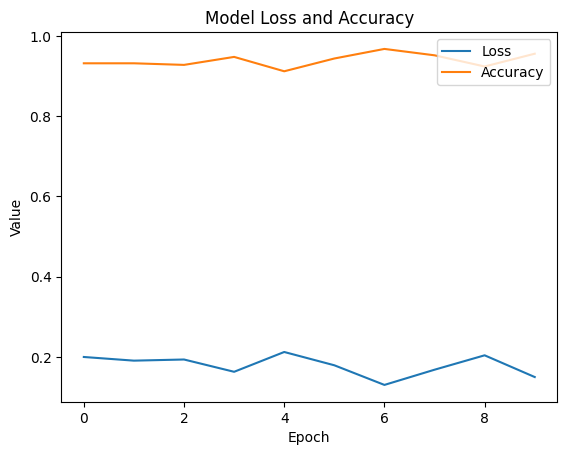

In [ ]:
epochs = 10
Sequential_history = Sequential_model.fit(train_dataset, epochs=epochs)

import pandas as pd
import matplotlib.pyplot as plt

plt.plot(Sequential_history.history['loss'], label='Loss')
plt.plot(Sequential_history.history['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.title('Model Loss and Accuracy')
plt.show()

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 701ms/step - accuracy: 0.9927 - loss: 0.0193
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 705ms/step - accuracy: 0.9991 - loss: 0.0115
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 711ms/step - accuracy: 0.9844 - loss: 0.0380
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 715ms/step - accuracy: 0.9930 - loss: 0.0297
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 721ms/step - accuracy: 0.9920 - loss: 0.0212
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 725ms/step - accuracy: 0.9872 - loss: 0.0463
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 743ms/step - accuracy: 0.9964 - loss: 0.0125
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 728ms/step - accuracy: 0.9925 - loss: 0.0276
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 745ms/step - accuracy: 0.9932 - loss: 0.0175
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 732ms/step - accuracy: 0.9875 - loss: 0.0454


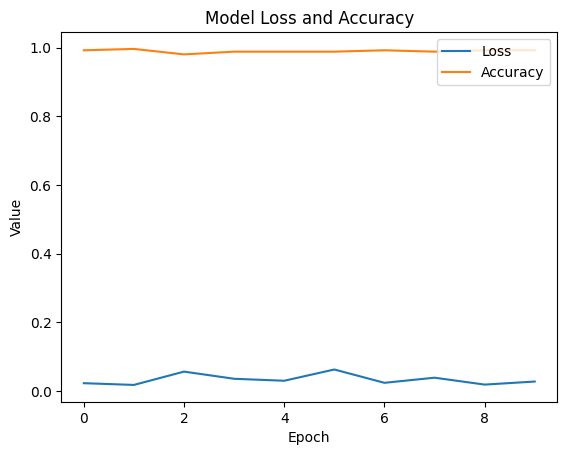

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
Xception_history = Xception_model.fit(train_dataset, epochs=epochs, batch_size=32)

import pandas as pd
import matplotlib.pyplot as plt

plt.plot(Xception_history.history['loss'], label='Loss')
plt.plot(Xception_history.history['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.title('Model Loss and Accuracy')
plt.show()

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.9770 - loss: 0.0562
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9780 - loss: 0.0986
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.9865 - loss: 0.0406
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.9833 - loss: 0.0416
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.9955 - loss: 0.0227
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.9791 - loss: 0.0808
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - accuracy: 0.9986 - loss: 0.0202
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 1.0000 - loss: 0.0086
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.9882 - loss: 0.0400
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9789 - loss: 0.0394


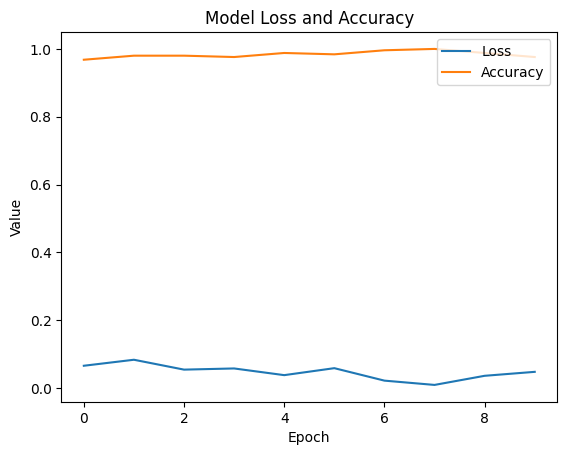

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
MobileNetV2_history = MobileNetV2_model.fit(train_dataset, epochs=epochs, batch_size=32)

import pandas as pd
import matplotlib.pyplot as plt

plt.plot(MobileNetV2_history.history['loss'], label='Loss')
plt.plot(MobileNetV2_history.history['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper right')
plt.title('Model Loss and Accuracy')
plt.show()

# 모델 평가하기 - Sequential_model

In [ ]:
score = Sequential_model.evaluate(test_dataset)       # 테스트 데이터셋 모델에 넣어 예측하기
print(f'accuracy : {round(score[1],2)}, loss : {round(score[0],2)}')

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7510 - loss: 2.0326
accuracy : 0.39, loss : 4.66


In [ ]:
Sequential_preds = Sequential_model.predict(test_dataset)    # 모델이 테스트 데이터셋을 예측한 값을 출력(softmax로 나왔기 때문에 모든 값의 합은 1)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
Sequential_preds = np.argmax(Sequential_preds, axis = 1)  # 예측한 값들 중에서 가장 큰 값을 출력
Sequential_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
import pandas as pd

df_result = pd.DataFrame(columns=['Actual', 'Predicted'])
df_result['Actual'] = test_dataset.classes
df_result['Predicted'] = Sequential_preds
df_result

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
61,2,0
62,2,0
63,2,0
64,2,0


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(test_dataset.classes, Sequential_preds)

0.3939393939393939

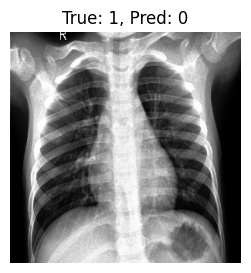

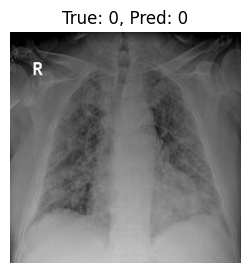

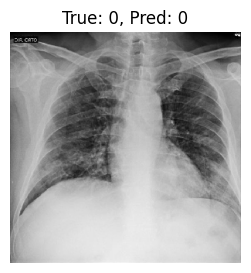

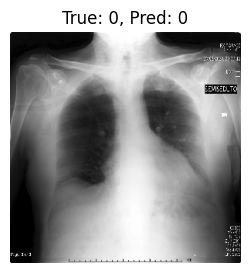

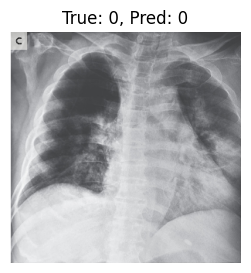

In [ ]:
# 시각화할 이미지 개수
import matplotlib.pyplot as plt
num_images = 5
samples_to_display = np.random.choice(len(test_dataset), num_images, replace=False)

# 테스트 데이터 중 일부 이미지 시각화
for i, idx in enumerate(samples_to_display):
    img, label = test_dataset[idx]  # 이미지와 레이블을 가져옵니다
    img = img[0]  # 배치 차원 제거
    true_label = test_dataset.classes[idx]
    pred_label = Sequential_preds[idx]
    plt.figure(figsize=(5, 3))
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()

# 모델 평가하기 - Xception_model

In [ ]:
score = Xception_model.evaluate(test_dataset)       # 테스트 데이터셋 모델에 넣어 예측하기
print(f'accuracy : {round(score[1],2)}, loss : {round(score[0],2)}')

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9650 - loss: 0.1900
accuracy : 0.8, loss : 1.07


In [ ]:
Xception_preds = Xception_model.predict(test_dataset)    # 모델이 테스트 데이터셋을 예측한 값을 출력(softmax로 나왔기 때문에 모든 값의 합은 1)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [ ]:
Xception_preds = np.argmax(Xception_preds, axis = 1)  # 예측한 값들 중에서 가장 큰 값을 출력
Xception_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1])

In [ ]:
import pandas as pd

df_result = pd.DataFrame(columns=['Actual', 'Predicted'])
df_result['Actual'] = test_dataset.classes
df_result['Predicted'] = Xception_preds
df_result

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
61,2,1
62,2,2
63,2,1
64,2,1


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(test_dataset.classes, Xception_preds)

0.803030303030303

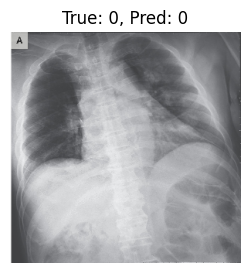

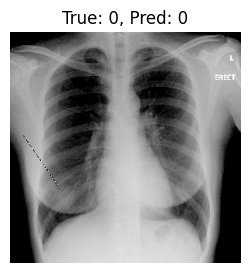

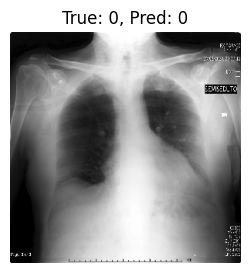

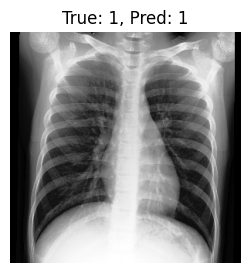

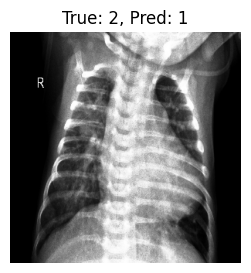

In [ ]:
# 시각화할 이미지 개수
import matplotlib.pyplot as plt
num_images = 5
samples_to_display = np.random.choice(len(test_dataset), num_images, replace=False)

# 테스트 데이터 중 일부 이미지 시각화
for i, idx in enumerate(samples_to_display):
    img, label = test_dataset[idx]  # 이미지와 레이블을 가져옵니다
    img = img[0]  # 배치 차원 제거
    true_label = test_dataset.classes[idx]
    pred_label = Xception_preds[idx]
    plt.figure(figsize=(5, 3))
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()

# 모델 평가하기 - MobileNetV2_model

In [ ]:
score = MobileNetV2_model.evaluate(test_dataset)       # 테스트 데이터셋 모델에 넣어 예측하기
print(f'accuracy : {round(score[1],2)}, loss : {round(score[0],2)}')

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8084 - loss: 6.3390
accuracy : 0.7, loss : 10.05


In [ ]:
MobileNetV2_preds = MobileNetV2_model.predict(test_dataset)    # 모델이 테스트 데이터셋을 예측한 값을 출력(softmax로 나왔기 때문에 모든 값의 합은 1)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [ ]:
MobileNetV2_preds = np.argmax(MobileNetV2_preds, axis = 1)  # 예측한 값들 중에서 가장 큰 값을 출력
MobileNetV2_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
import pandas as pd

df_result = pd.DataFrame(columns=['Actual', 'Predicted'])
df_result['Actual'] = test_dataset.classes
df_result['Predicted'] = MobileNetV2_preds
df_result

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
61,2,2
62,2,2
63,2,2
64,2,2


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(test_dataset.classes, MobileNetV2_preds)

0.696969696969697

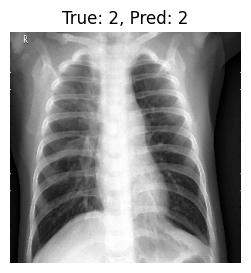

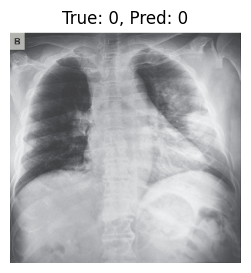

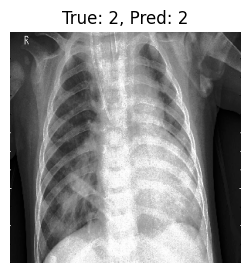

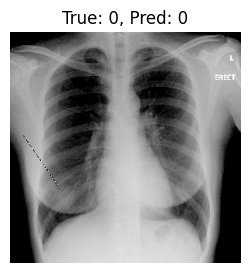

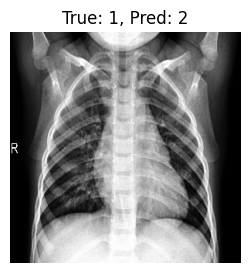

In [ ]:
# 시각화할 이미지 개수
import matplotlib.pyplot as plt
num_images = 5
samples_to_display = np.random.choice(len(test_dataset), num_images, replace=False)

# 테스트 데이터 중 일부 이미지 시각화
for i, idx in enumerate(samples_to_display):
    img, label = test_dataset[idx]  # 이미지와 레이블을 가져옵니다
    img = img[0]  # 배치 차원 제거
    true_label = test_dataset.classes[idx]
    pred_label = MobileNetV2_preds[idx]
    plt.figure(figsize=(5, 3))
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()

# 모델 저장 및 로드

In [ ]:
from keras.models import save_model
from keras.models import load_model
import tensorflow as tf
import os

if os.path.exists('Covid19_model.h5'):
    os.remove('Covid19_model.h5')
    print("Existing 'Covid19_model.h5' file removed.")

if os.path.exists('/content/Covid19.hdf5'):
    os.remove('/content/Covid19.hdf5')
    print("Existing '/content/Covid19.hdf5' file removed.")

# 모델 전체를 'model.h5' 파일로 저장
save_model(model, 'Covid19_model.h5')

# 모델의 구조를 JSON 문자열로 반환-모델을 구성하는 각 레이어의 구성과 설정이 포함
with open('trained_model.json', 'w') as trained_model_json:
    trained_model_json.write(model.to_json())

# 모델 구조 로드하기
with open('trained_model.json', 'r') as trained_model_json:
    trained_model_json = trained_model_json.read()

# 모델 가중치 저장하기
save_model(model, '/content/Covid19.hdf5')

# Load the trained model & weights
model = tf.keras.models.model_from_json(trained_model_json)
model.load_weights('/content/Covid19.hdf5')